UQ360/examples/infinitesimal_jackknife/demo_infinitesimal_jackknife.ipynb

In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from uq360.algorithms.infinitesimal_jackknife.infinitesimal_jackknife import InfinitesimalJackknife
from uq360.utils.logistic_regression import LogisticRegression, get_num_train, logistic_predictions

In this notebook, we will illustrate infinitesimal jackknife (IJ) for logistic regression. 

## Fit the model to simulated data

#### Generate synthetic data
$x \sim N(0, \sigma^2I_D)$

$w \sim N (0, I)$

$y \sim Bernoulli(p = sigmoid(w^Tx))$ 

and instantiate the logistic regression model.

In [3]:
lr = LogisticRegression()
# generate simulated data
inputs, targets, test_inputs, test_targets = lr.synthetic_lr_data(N=1000, D=10)

#### Fit by maximizing the likelihood

In [6]:
# Standard MLE model fit
init_params = 1e-1 * np.random.randn(inputs.shape[1])
weights_one = np.ones([1, get_num_train(inputs)])
params_one = lr.fit(weights_one, init_params, inputs, targets)
print("Maximum Likelihood Solution's Test Accuracy {0:0.3f}".format(
lr.get_test_acc(params_one, test_targets, test_inputs)))

Initial loss: 657.0034124381663
Optimization terminated successfully.
         Current function value: 218.806658
         Iterations: 31
         Function evaluations: 42
         Gradient evaluations: 42
Trained loss: 218.80665769320925
Maximum Likelihood Solution's Test Accuracy 0.783


## Infinitesimal Jackknife Approximations

Now that we have fit the model and precomputed things we will precompute stuff needed the IJ approximation -- the Hessian and the per datapoint loss gradients. Remember we need to do this only once.  

In [5]:
# Precompute some stuff needed for IJ approximation
H = lr.compute_hessian(params_one, weights_one, inputs, targets)
J = lr.compute_jacobian(params_one, weights_one, inputs, targets)
config = {"alpha": 0.01, "resampling_strategy": 'jackknife'}
ij = InfinitesimalJackknife(params_one, J, H, config)

#### Let's approximate the effect of leaving out datapoint 957 on the parameters of the logistic regression model

In [7]:
# Set the 957th coordinate in the weight vector to zero
weights = np.ones_like(weights_one)
weights[0, 957] = 0

# approximate jackknife
ij_params = ij.ij(weights.squeeze())

# make predictions with this approximated parameter for the left out datum
lr.set_parameters(ij_params)
y_pred_approx = lr.predict(inputs[957])

print ("Probability of class 1 as approximated by IJ: {0:f}".format(y_pred_approx.squeeze()))

Probability of class 1 as approximated by IJ: 0.999189


## Is IJ an accurate approximation to Exact Jackknife?

First we will verify that infinitesimal jackknife is a good approximation to exact jackknife.
We will do so by running exact jackknife on a subset of the data and comparing with IJ.

Mean Absolute Deviation between approximate and exact jackknife:  7.38416630749389e-05


Text(0, 0.5, 'IJ')

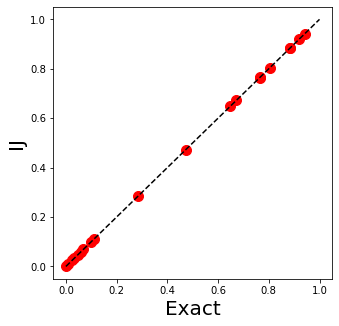

In [13]:
# compare approximate with exact jackknife for a few points
weights = np.ones_like(weights_one)
y_pred_exact = np.zeros([20, 1])
y_pred_approx = np.zeros([20, 1])
y_pred_mle = np.zeros([20, 1])
for i in np.arange(20):
    weights[0, i] = 0
    params = lr.fit(weights, params_one, inputs, targets, verbose=False)
    lr.set_parameters(params)
    y_pred_exact[i] = lr.predict(inputs[i])
    ij_params = ij.ij(weights.squeeze())
    lr.set_parameters(ij_params)
    y_pred_approx[i] = lr.predict(inputs[i])
    lr.set_parameters(params_one)
    y_pred_mle[i] = lr.predict(inputs[i])
    weights[0, i] = 1

print("Mean Absolute Deviation between approximate and exact jackknife: ",
      np.mean(np.abs(y_pred_approx - y_pred_exact)))

plt.figure(figsize=(5,5))
plt.plot(y_pred_exact, y_pred_approx, 'ro', ms=10)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Exact", fontsize=20)
plt.ylabel("IJ", fontsize=20)

As we can see, there is strong agreement between exact and approximate (IJ) jackknife.

## Predictive uncertainties
Next, we will use IJ to get predictive uncertainties.

In [14]:
y_pred, y_lb, y_ub = ij.predict(test_inputs, lr)

In [15]:
np.set_printoptions(precision=3)
# let's look at some of the predictions; we will visualize 20 data points with the  largest uncertainties.
pi = y_ub - y_lb
idx = np.argsort(-pi.ravel())
# plt.plot(y_pred[:20], np.arange(20), 'ro', ms=1)
for i, v in enumerate(idx[:20]):
    print ("{0}, {1}, {2}".format(y_lb[v], y_pred[v], y_ub[v]))
    

[0.551], [0.566], [0.581]
[0.592], [0.604], [0.619]
[0.716], [0.727], [0.742]
[0.337], [0.35], [0.362]
[0.331], [0.345], [0.355]
[0.283], [0.295], [0.306]
[0.433], [0.445], [0.456]
[0.567], [0.577], [0.589]
[0.512], [0.523], [0.534]
[0.339], [0.351], [0.361]
[0.416], [0.427], [0.438]
[0.445], [0.456], [0.466]
[0.614], [0.625], [0.635]
[0.698], [0.707], [0.719]
[0.733], [0.742], [0.753]
[0.409], [0.419], [0.429]
[0.365], [0.376], [0.385]
[0.679], [0.688], [0.698]
[0.297], [0.308], [0.317]
[0.184], [0.194], [0.203]


# Delete-d jackknife
Instead of leaving one data point out, we could ask what happens when we leave out d datapoints

In [16]:
# Approximate the effect of holding out d = 20 datapoints at one go.
d = 20
idx = np.random.choice(np.arange(1000), d)
idx

array([977, 125, 557, 805, 408, 184, 940, 659, 544, 560, 283, 168, 991,
       414, 956, 625,  41, 585, 237,  87])

In [17]:
weights = np.ones_like(weights_one)
weights[0, idx] = 0

In [18]:
# approximate jackknife
ij_params = ij.ij(weights.squeeze())

# make predictions with this approximated parameter for the left out datum
lr.set_parameters(ij_params)
y_pred_approx = lr.predict(inputs[idx])

print ("Probability of class 1 as approximated by IJ: {}".format(y_pred_approx.squeeze()))

Probability of class 1 as approximated by IJ: [0.999 0.879 0.501 0.004 0.305 0.985 0.007 0.569 0.523 1.    1.    1.
 0.998 0.316 0.077 0.245 0.561 0.221 0.022 0.27 ]


In [19]:
params = lr.fit(weights, params_one, inputs, targets, verbose=False)
lr.set_parameters(params)
y_pred_exact = lr.predict(inputs[idx])

Text(0, 0.5, 'IJ')

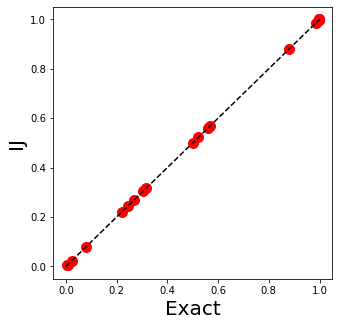

In [20]:
plt.figure(figsize=(5,5))
plt.plot(y_pred_exact, y_pred_approx, 'ro', ms=10)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Exact", fontsize=20)
plt.ylabel("IJ", fontsize=20)

## Other weighting

schemes can be used just as easily. Some might not have a clear interpretation though!


In [21]:
weights = np.ones_like(weights_one)
weights[0, 1] = 0.5 # downweight
weights[0, 2] = 10. # upweight
weights[0, 3] = -1. # negative weights
ij_params = ij.ij(weights.squeeze())

# Structured Models --- Hidden Markov Models, Markov Random Fields
You can drop data from within the structure --- time points in a HMM, sites in a MRF. Needs a weighted version of  belief propagation. 

See demo_structured_infinitesimal_jackknife.ipynb